In [1]:
import re
import math
import time
import codecs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from functools import wraps
from datetime import datetime

from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KernelDensity

import keras.backend as K
from keras.layers import Dense,Input,Flatten,concatenate,Dropout,Lambda, BatchNormalization
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, KFold

%matplotlib inline

Using TensorFlow backend.


In [2]:
# TRAIN_DATA_PATH = Path('../input/nfl-big-data-bowl-2020/train.csv')
TRAIN_DATA_PATH = Path('../src/vector_build/train.csv')
SEED = 0

In [3]:
train = pd.read_csv(TRAIN_DATA_PATH, dtype={'WindSpeed': 'object'})
train.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [4]:
replacements = [
    ('LSU', 'Louisiana State'),
    ('Southern California', 'USC'),
    ('Miami (Fla.)', 'Miami'),
    ('Miami, O.', 'Miami OH'),
    ('Miami (Ohio)', 'Miami OH'),
    ('Texas-El Paso', 'Texas')
]

In [5]:
college_to_conf = {
    'Air Force' : 'Mountain West Conference',
    'Akron' : 'Mid-American Conference',
    'Alabama' : 'Southeastern Conference',
    'Alabama-Birmingham' : 'Conference USA',
    'Appalachian State' : 'Sun Belt Conference',
    'Arizona' : 'Pacific 12 Conference',
    'Arizona State' : 'Pacific 12 Conference',
    'Arkansas' : 'Southeastern Conference',
    'Arkansas State' : 'Sun Belt Conference',
    'Army' : 'Independents',
    'Auburn' : 'Southeastern Conference',
    'Ball State' : 'Mid-American Conference',
    'Baylor' : 'Big 12 Conference',
    'Boise State' : 'Mountain West Conference',
    'Boston College' : 'Atlantic Coast Conference',
    'Bowling Green' : 'Mid-American Conference',
    'Brigham Young' : 'Independents',
    'Buffalo' : 'Mid-American Conference',
    'California' : 'Pacific 12 Conference',
    'Central Florida' : 'American Athletic Conference',
    'Central Michigan' : 'Mid-American Conference',
    'Cincinnati' : 'American Athletic Conference',
    'Clemson' : 'Atlantic Coast Conference',
    'Coastal Carolina' : 'Sun Belt Conference',
    'Colorado' : 'Pacific 12 Conference',
    'Colorado State' : 'Mountain West Conference',
    'Connecticut' : 'American Athletic Conference',
    'Duke' : 'Atlantic Coast Conference',
    'East Carolina' : 'American Athletic Conference',
    'Eastern Michigan' : 'Mid-American Conference',
    'Florida' : 'Southeastern Conference',
    'Florida Atlantic' : 'Conference USA',
    'Florida International' : 'Conference USA',
    'Florida State' : 'Atlantic Coast Conference',
    'Fresno State' : 'Mountain West Conference',
    'Georgia' : 'Southeastern Conference',
    'Georgia Southern' : 'Sun Belt Conference',
    'Georgia State' : 'Sun Belt Conference',
    'Georgia Tech' : 'Atlantic Coast Conference',
    'Hawai`i' : 'Mountain West Conference',
    'Houston' : 'American Athletic Conference',
    'Illinois' : 'Big 10 Conference',
    'Indiana' : 'Big 10 Conference',
    'Iowa' : 'Big 10 Conference',
    'Iowa State' : 'Big 12 Conference',
    'Kansas' : 'Big 12 Conference',
    'Kansas State' : 'Big 12 Conference',
    'Kent State' : 'Mid-American Conference',
    'Kentucky' : 'Southeastern Conference',
    'Liberty' : 'Independents',
    'Louisiana Tech' : 'Conference USA',
    'Louisiana-Lafayette' : 'Sun Belt Conference',
    'Louisiana-Monroe' : 'Sun Belt Conference',
    'Louisville' : 'Atlantic Coast Conference',
    'Louisiana State' : 'Southeastern Conference',
    'Marshall' : 'Conference USA',
    'Maryland' : 'Big 10 Conference',
    'Massachusetts' : 'Independents',
    'Memphis' : 'American Athletic Conference',
    'Miami' : 'Atlantic Coast Conference',
    'Miami OH' : 'Mid-American Conference',
    'Michigan' : 'Big 10 Conference',
    'Michigan State' : 'Big 10 Conference',
    'Middle Tennessee State' : 'Conference USA',
    'Minnesota' : 'Big 10 Conference',
    'Mississippi' : 'Southeastern Conference',
    'Mississippi State' : 'Southeastern Conference',
    'Missouri' : 'Southeastern Conference',
    'Navy' : 'American Athletic Conference',
    'Nebraska' : 'Big 10 Conference',
    'Nevada' : 'Mountain West Conference',
    'New Mexico' : 'Mountain West Conference',
    'New Mexico State' : 'Independents',
    'North Carolina' : 'Atlantic Coast Conference',
    'North Carolina State' : 'Atlantic Coast Conference',
    'North Texas' : 'Conference USA',
    'Northern Illinois' : 'Mid-American Conference',
    'Northwestern' : 'Big 10 Conference',
    'Notre Dame' : 'Independents',
    'Ohio State' : 'Big 10 Conference',
    'Ohio' : 'Mid-American Conference',
    'Oklahoma' : 'Big 12 Conference',
    'Oklahoma State' : 'Big 12 Conference',
    'Old Dominion' : 'Conference USA',
    'Oregon' : 'Pacific 12 Conference',
    'Oregon State' : 'Pacific 12 Conference',
    'Penn State' : 'Big 10 Conference',
    'Pittsburgh' : 'Atlantic Coast Conference',
    'Purdue' : 'Big 10 Conference',
    'Rice' : 'Conference USA',
    'Rutgers' : 'Big 10 Conference',
    'San Diego State' : 'Mountain West Conference',
    'San Jose State' : 'Mountain West Conference',
    'SMU' : 'American Athletic Conference',
    'South Alabama' : 'Sun Belt Conference',
    'South Carolina' : 'Southeastern Conference',
    'South Florida' : 'American Athletic Conference',
    'USC' : 'Pacific 12 Conference',
    'Southern Miss' : 'Conference USA',
    'Stanford' : 'Pacific 12 Conference',
    'Syracuse' : 'Atlantic Coast Conference',
    'Texas Christian' : 'Big 12 Conference',
    'Temple' : 'American Athletic Conference',
    'Tennessee' : 'Southeastern Conference',
    'Texas' : 'Big 12 Conference',
    'Texas A&M' : 'Southeastern Conference',
    'Texas State' : 'Sun Belt Conference',
    'Texas Tech' : 'Big 12 Conference',
    'Texas-San Antonio' : 'Conference USA',
    'Toledo' : 'Mid-American Conference',
    'Troy' : 'Sun Belt Conference',
    'Tulane' : 'American Athletic Conference',
    'Tulsa' : 'American Athletic Conference',
    'UCLA' : 'Pacific 12 Conference',
    'UNC-Charlotte' : 'Conference USA',
    'UNLV' : 'Mountain West Conference',
    'Utah' : 'Pacific 12 Conference',
    'Utah State' : 'Mountain West Conference',
    'UTEP' : 'Conference USA',
    'Vanderbilt' : 'Southeastern Conference',
    'Virginia' : 'Atlantic Coast Conference',
    'Virginia Tech' : 'Atlantic Coast Conference',
    'Wake Forest' : 'Atlantic Coast Conference',
    'Washington' : 'Pacific 12 Conference',
    'Washington State' : 'Pacific 12 Conference',
    'West Virginia' : 'Big 12 Conference',
    'Western Kentucky' : 'Conference USA',
    'Western Michigan' : 'Mid-American Conference',
    'Wisconsin' : 'Big 10 Conference',
    'Wyoming' : 'Mountain West Conference'
}

In [6]:
position_groups = {
    'CB' : 'DB',
    'FS' : 'DB',
    'SAF' : 'DB',
    'S' : 'DB',
    'SS' : 'DB',
    'DB' : 'DB',
    'OLB' : 'LB',
    'ILB' : 'LB',
    'MLB' : 'LB',
    'LB' : 'LB',
    'DE' : 'DL',
    'DT' : 'DL',
    'NT' : 'DL',
    'DL' : 'DL',
    'G' : 'OL',
    'OG' : 'OL',
    'T' : 'OL',
    'OT' : 'OL',
    'C' : 'OL',
    'RB' : 'RB',
    'FB' : 'RB',
    'HB' : 'RB',
    'WR' : 'SK',
    'QB' : 'SK',
    'TE' : 'SK'
}
posession_positions = {
    'DB': 0,
    'LB': 0,
    'DL': 0,
    'OL': 1,
    'RB': 1,
    'SK': 1
}

In [7]:
COLS_TO_DROP = [
    'Position', 'IsRusher'
]
CATEGORICAL_VARS = [
    'DisplayName', 'PlayerCollegeName', 'GameWeather', 'Location',
    'OffensePersonnel', 'Stadium', 'WindDirection', 'DefensePersonnel',
    'HomeTeamAbbr', 'VisitorTeamAbbr', 'FieldPosition', 'PossessionTeam',
    'StadiumType', 'Position', 'Turf', 'PlayerHeight', 'OffenseFormation',
    'JerseyNumber', 'NflId'
]
TRANSFORMED_CATEGORICALS = [
    'OffensePersonnel', 'DefensePersonnel', 'WindSpeed', 'PlayerHeight',
    'NflId', 'Turf', 'FieldPosition', 'PlayerCollegeName', 'JerseyNumber',
    'PossessionTeam'
]
VARS_TO_ONE_HOT = [var for var in CATEGORICAL_VARS
                   if var not in TRANSFORMED_CATEGORICALS
                   and var not in COLS_TO_DROP]
MAX_CARDINALITY = 24

In [8]:
cardinalities = train[VARS_TO_ONE_HOT].nunique().sort_values(ascending=False)
cardinalities

DisplayName         2230
GameWeather           61
Location              60
Stadium               55
WindDirection         53
VisitorTeamAbbr       32
HomeTeamAbbr          32
StadiumType           29
OffenseFormation       8
dtype: int64

In [9]:
def shoelace(x, y):
    return 0.5 * np.abs(np.dot(x, np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [10]:
def func_timer(fn):
    @wraps(fn)
    def timer(*args, **kwargs):
        print('\n' + fn.__name__.upper())
        start_time = datetime.now()
        res = fn(*args, **kwargs)
        end_time = datetime.now()
        time_taken = end_time - start_time
        time_taken = time_taken.total_seconds() / 60
        print('{} time taken: {:.2f} mins'.format(fn.__name__, time_taken))
        return res
    return timer

def transformation_check(fn):
    @wraps(fn)
    def checker(*args, **kwargs):
        print(' -- {} -- '.format(fn.__name__))
        res = fn(*args, **kwargs)
        end_shape = res.shape
        null_prc = 100 * (res.isnull().sum() / len(res)).mean()
        print('\tshape = {}'.format(end_shape))
        print('\tnull % = {:.2f}'.format(null_prc))
        return res
    return checker

In [11]:
class Preprocessor(TransformerMixin):
    def __init__(self, one_hot_vars, max_cardinality, cols_to_drop=[]):
        super().__init__()
        self.target = 'Yards'
        self.one_hot_vars = one_hot_vars
        self.max_cardinality = max_cardinality
        self.cols_to_drop = cols_to_drop
        self.player_cols = []
        self.one_hot_encoder = OneHotEncoder(
            sparse=False, 
            dtype=np.int, 
            handle_unknown='ignore'
        )
        self.college_encoding = {}
        self.jersey_encoding = {}

    @func_timer
    def initial_cleaning(self, X):
        """ Transformative steps that don't need any 'fitted'
        objects. Also any thing that needs to be done before anything
        is fit """
        X = self._correct_team_abbreviations(X)
        X = self._encode_player_height(X)
        X = self._process_time_variables(X)
        X = self._fix_wind_variables(X)
        X = self._fix_stadium_type_and_turf(X)
        X = self._map_college_and_pos(X)
        X = self._encode_personnel(X)
        X = self._normalise_positional_data(X)
        X = self._calc_voronoi(X)
        X = self._misc_engineering(X)
        X.drop(columns=self.cols_to_drop, inplace=True)
        return X

    @func_timer
    def fit(self, X, y=None):
        # Get player related columns
        self._get_player_cols(X)

        # Fit one hot encoder
        cardinalities = X[self.one_hot_vars].nunique().to_dict()
        one_hot_vars = [var for var in self.one_hot_vars
                        if cardinalities[var] <= self.max_cardinality]
        self.one_hot_encoder.fit(X[one_hot_vars].fillna('unknown'))
        self.oh_cols_to_drop = [var for var in self.one_hot_vars
                                if var not in one_hot_vars]
        self.one_hot_vars = one_hot_vars
        
        # Fit college name and jersey number 'encoder's
        self.college_encoding = \
            X.groupby('PlayerCollegeName')['PlayId'].count().to_dict()
        self.jersey_encoding = \
            X.groupby('JerseyNumber')['PlayId'].count().to_dict()
        
        return self

    @func_timer
    def transform(self, X):
        X['PlayerCollegeName'] = X['PlayerCollegeName'].map(self.college_encoding)
        X['PlayerCollegeNameRusher'] = \
            X['PlayerCollegeNameRusher'].map(self.college_encoding)
        X['JerseyNumber'] = X['JerseyNumber'].map(self.jersey_encoding)
        X = self._apply_one_hot_encoder(X)
        X = self._flatten_player_vars(X)
#         X = self._previous_play_data(X)
        return X

    @transformation_check
    def _correct_team_abbreviations(self, X):
        map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
        for abb in X['PossessionTeam'].unique():
            map_abbr[abb] = abb

        X['PossessionTeam'] = X['PossessionTeam'].map(map_abbr)
        X['HomeTeamAbbr'] = X['HomeTeamAbbr'].map(map_abbr)
        X['VisitorTeamAbbr'] = X['VisitorTeamAbbr'].map(map_abbr)
        return X

    @transformation_check
    def _encode_player_height(self, X):
        def string_to_inches(x):
            feet, inch = x.split('-')
            return int(inch) + 12 * int(feet)

        X['PlayerHeight'] = X['PlayerHeight'].apply(string_to_inches)
        return X

    @transformation_check
    def _process_time_variables(self, X):
        for col in ['TimeHandoff', 'TimeSnap', 'PlayerBirthDate']:
            X[col] = pd.to_datetime(X[col], utc=True, infer_datetime_format=True)
        X['TimeUntilHandoff'] = X['TimeSnap'] - X['TimeHandoff']
        X['TimeUntilHandoff'] = X['TimeUntilHandoff'].dt.total_seconds()

        X['PlayerAge'] = X['TimeSnap'] - X['PlayerBirthDate']
        X['PlayerAge'] = X['PlayerAge'].dt.total_seconds() / 31556952

        X['GameClock'] = 360 * X['GameClock'].str[:2].astype(int) \
                         + 60 * X['GameClock'].str[3:5].astype(int) \
                         + X['GameClock'].str[6:8].astype(int)

        X.drop(columns=['TimeHandoff', 'TimeSnap', 'PlayerBirthDate'], inplace=True)
        return X

    @transformation_check
    def _fix_wind_variables(self, X):
        def average_ranges(x):
            x = str(x)
            if '-' in x:
                low, high = x.split('-')
                return str((int(high) + int(low)) / 2)
            elif ' gusts up to ' in x:
                low, high = x.split(' gusts up to ')
                return str((int(high) + int(low)) / 2)
            else:
                return x

        def coerce_to_int(x):
            try:
                x = int(x)
            except:
                x = np.nan
            return x

        X['WindSpeed'] = X['WindSpeed'].str.lower().str.replace('mph', '')
        X['WindSpeed'] = X['WindSpeed'].str.strip()
        X['WindSpeed'] = X['WindSpeed'].apply(average_ranges)
        X['WindSpeed'] = X['WindSpeed'].apply(coerce_to_int)

        acceptable_directions = [
            'NE', 'SW', 'S', 'NW', 'WSW', 'SE', 'W', 'N', 'NNE', 'WNW', 'SSW',
            'NNW', 'SSE', 'E', 'ENE', 'ESE'
        ]
        X['WindDirection'] = X['WindDirection'].str.upper()
        X['WindDirection'] = X['WindDirection'].str.replace('FROM ', '').str.replace('-', '')
        X.loc[~X['WindDirection'].isin(acceptable_directions), 'WindDirection'] = np.nan
        return X
    
    @transformation_check
    def _fix_stadium_type_and_turf(self, X):
        stadium_type_map = {
            'Outdoor': 'Outdoor',
            'Outdoors': 'Outdoor',
            'Indoors': 'Indoor',
            'Dome': 'Indoor',
            'Indoor': 'Indoor',
            'Retractable Roof': 'Retr Open',
            'Open': 'Retr Open',
            'Retr. Roof-Closed': 'Retr Closed',
            'Retr. Roof - Closed': 'Retr Closed',
            'Domed, closed': 'Retr Closed',
            'Domed, open': 'Retr Open',
            'Closed Dome': 'Retr Closed',
            'Dome, closed': 'Retr Closed',
            'Domed': 'Indoor',
            'Oudoor': 'Outdoor',
            'Indoor, Roof Closed': 'Retr Closed',
            'Retr. Roof Closed': 'Retr Closed',
            'Retr. Roof-Open': 'Retr Open',
            'Bowl': 'Outdoor',
            'Outddors': 'Outdoor',
            'Heinz Field': 'Outdoor',
            'Outdoor Retr Roof-Open': 'Retr Open',
            'Retr. Roof - Open': 'Retr Open',
            'Indoor, Open Roof': 'Retr Open',
            'Ourdoor': 'Outdoor',
            'Outdor': 'Outdoor',
            'Outside': 'Outdoor',
            'Cloudy': 'Outdoor',
            'Domed, Open': 'Retr Open'
        }
        X['StadiumType'] = X['StadiumType'].map(stadium_type_map)
        
        grass_labels = ['grass', 'natural grass', 'natural', 'naturall grass']
        X['Turf'] = np.where(X['Turf'].str.lower().isin([grass_labels]), 1, 0)
        
        def get_city(x):
            x = x.replace('e.', 'east').replace('.', ',')
            return x.split(',')[0].strip().lower()
        X['Location'] = X['Location'].apply(get_city)
        
        return X
    
    @transformation_check
    def _map_college_and_pos(self, X):
        for replacement in replacements:
            X['PlayerCollegeName'] = X['PlayerCollegeName']\
                .replace(replacement[0], replacement[1])
        X['CollegeConference'] = X['PlayerCollegeName'].map(college_to_conf)
        X['CollegeConference'].fillna('BinJuice', inplace=True)
        if 'CollegeConference' not in self.one_hot_vars:
            self.one_hot_vars += ['CollegeConference']
        
        X['PositionGroup'] = X['Position'].map(position_groups)
        X['InPossesion'] = X['PositionGroup'].map(posession_positions)
        return X

    @transformation_check
    def _encode_personnel(self, X):

        def count_positions(x, offensive):
            offensive_counts = {'DB': 0, 'DL': 0, 'LB': 0, 'OL': 0, 'QB': 0, 'RB': 0, 'TE': 0, 'WR': 0}
            defensive_counts = {'DB': 0, 'DL': 0, 'LB': 0, 'OL': 0}
            if offensive:
                val_counts=offensive_counts
            else:
                val_counts=defensive_counts

            if isinstance(x, str):
                for position_val in x.split(','):
                    val, pos = position_val.strip().split(' ')
                    if pos in val_counts:
                        val_counts[pos] += int(val)
            return val_counts
        
        X['OffensePersonnel'] = X['OffensePersonnel'] \
            .apply(count_positions, offensive=True)
        off_personnel_df = pd.DataFrame().from_records(X['OffensePersonnel'].values)
        off_personnel_df.index = X.index
        off_personnel_df.columns = ['NOffensive' + col for col in off_personnel_df.columns]

        X['DefensePersonnel'] = X['DefensePersonnel'] \
            .apply(count_positions, offensive=False)
        def_personnel_df = pd.DataFrame().from_records(X['DefensePersonnel'].values)
        def_personnel_df.index = X.index
        def_personnel_df.columns = ['NDefensive' + col for col in def_personnel_df.columns]

        X.drop(columns=['OffensePersonnel', 'DefensePersonnel'], inplace=True)
        X = pd.concat([X, off_personnel_df, def_personnel_df], axis=1)
        return X
    
    @transformation_check
    def _normalise_positional_data(self, X):
        X['IsLeftDirection'] = X['PlayDirection'] == 'left'
        
        X['PossesionInOwnHalf'] = X['PossessionTeam'] == X['FieldPosition']
        possession_in_own_half = X.groupby(['GameId', 'PlayId'])['PossesionInOwnHalf'].max().reset_index()
        X = X.drop(columns='PossesionInOwnHalf')\
            .merge(possession_in_own_half, on=['GameId', 'PlayId'])
        
        X['DistToEndZone'] = X['YardLine']
        X.loc[X['PossesionInOwnHalf'], 'DistToEndZone'] = 50 + (50 - X['YardLine'])
        X.loc[X['YardLine'] == 50, 'DistToEndZone'] = 50
        X['YardLineStd'] = 100 - X['DistToEndZone']
        
        X['XStd'] = X['X']
        X.loc[X['IsLeftDirection'], 'XStd'] = 120 - X.loc[X['IsLeftDirection'], 'X']
        
        X['YStd'] = X['Y']
        X.loc[X['IsLeftDirection'], 'YStd'] = 160 / 3 - X.loc[X['IsLeftDirection'], 'Y']
        
        X['PlayerDistToEndZone'] = 100 - (X['XStd'] - 10)
        
        X['DirRad'] = np.mod(90 - X['Dir'], 360) * math.pi / 180.0
        X['DirStd'] = X['DirRad']
        X.loc[X['IsLeftDirection'], 'DirStd'] = \
            np.mod(np.pi + X.loc[X['IsLeftDirection'], 'DirRad'], 2*np.pi)
        
        # Fix the problem with orientation over the years
        X['OrientationRad'] = np.mod(X['Orientation'], 360) * math.pi / 180.0
        X.loc[X['Season'] >= 2018, 'OrientationRad'] \
            = np.mod(X.loc[X['Season'] >= 2018, 'Orientation'] - 90, 360) * math.pi / 180.0
        
        X['OrientationStd'] = X['OrientationRad']
        X.loc[X['IsLeftDirection'], 'OrientationStd'] = \
            np.mod(np.pi + X.loc[X['IsLeftDirection'], 'OrientationRad'], 2 * np.pi)
        X.drop(columns=['OrientationRad'], inplace=True)
        
        X['IsLeftDirection'] = (X['IsLeftDirection']).astype(int)
        X['IsRusher'] = (X['NflId'] == X['NflIdRusher']).astype(int)
        return X
    
    @transformation_check
    def _calc_voronoi(self, X):
        max_voronoi = 120 * 53.3
        X['VoronoiArea'] = 0
        X['VoronoiAreaNoOffence'] = 0
        for play_id in X['PlayId'].unique():
            play = X.loc[X['PlayId'] == play_id].copy()

            # Only consider space 5 yards behind the player furthest back
            x_cut_off = play['XStd'].min() - 5

            # Also calculate the rusher's voronoi excluding team mates
            no_offence_play = play[play['IsRusher'].astype(bool) |
                                   ~play['InPossesion'].astype(bool)]

            def mirror_boundary(xy):
                xy = xy.values
                n_points = xy.shape[0]
                xy1 = xy.copy()
                xy1[:,1] = -xy[:,1]
                xy2 = xy.copy()
                xy2[:,1] = 320/3 - xy[:,1]
                xy3 = xy.copy()
                xy3[:,0] = 2 * x_cut_off - xy[:,0]
                xy4 = xy.copy()
                xy4[:,0] = 220 - xy[:,0]
                return np.concatenate((xy, xy1, xy2, xy3, xy4), axis=0), n_points

            # Get voronoi
            xy, n = mirror_boundary(play[['XStd', 'YStd']])
            vor = Voronoi(xy)

            no_off_xy, _ = mirror_boundary(no_offence_play[['XStd', 'YStd']])
            no_off_vor = Voronoi(no_off_xy)

            # Calculate space area
            areas = np.zeros([play.shape[0], ])
            for i in range(n):
                player_point = vor.point_region[i]
                vertices = vor.vertices[vor.regions[player_point]]
                areas[i] = shoelace(vertices[:, 0], vertices[:, 1])

            rusher_index = np.argmax(no_offence_play['IsRusher'].values)
            rusher_index_in_df = no_offence_play.index.values[rusher_index]
            rusher_region = no_off_vor.point_region[rusher_index]
            rusher_vertex_index = no_off_vor.regions[rusher_region]
            rusher_vertices = no_off_vor.vertices[rusher_vertex_index]
            rusher_area = shoelace(rusher_vertices[:, 0], rusher_vertices[:, 1])

            # Assign to main df
            X.loc[play.index, 'VoronoiArea'] = areas
            X.loc[rusher_index_in_df, 'VoronoiAreaNoOffence'] = min(rusher_area, max_voronoi)
            
        X.loc[X['VoronoiArea'] > max_voronoi, 'VoronoiArea'] = max_voronoi
        return X

    @transformation_check
    def _misc_engineering(self, X):
        X['ScoreDiff'] = X['HomeScoreBeforePlay'] - X['VisitorScoreBeforePlay']
        # Set binary variables
        X['IsAwayTeam'] = (X['Team'] == 'away').astype(int)
        X['IsInAwayEnd'] = (X['FieldPosition'] == X['VisitorTeamAbbr']).astype(int)
        X['HomePossesion'] = (X['PossessionTeam'] == X['HomeTeamAbbr']).astype(int)
        X['AwayInPosession'] = (X['InPossesion'] == X['IsAwayTeam']).astype(int)
        # Directional features
        X['SX'] = X['S'] * np.cos(X['DirStd'])
        X['SY'] = X['S'] * np.sin(X['DirStd'])
        X['AX'] = X['A'] * np.cos(X['DirStd'])
        X['AY'] = X['A'] * np.sin(X['DirStd'])
        X['OrientationCos'] = X['OrientationStd'] * np.cos(X['DirStd'])
        X['OrientationSin'] = X['OrientationStd'] * np.sin(X['DirStd'])
        # Closeness to scrimmage line
        X['XToScrimmage'] = X['YardLineStd'] - X['XStd']
        
        # Get Rusher features
        rusher_pos = X.loc[
            X['IsRusher'] == 1, 
            ['XStd', 'YStd', 'DirStd', 'S', 'SX', 'SY', 'A', 'AX', 'AY', 
             'Position', 'GameId', 'PlayId', 'PlayerCollegeName', 'Dis',
             'XToScrimmage', 'PlayerDistToEndZone', 'OrientationStd', 'OrientationCos',
             'OrientationSin', 'VoronoiArea', 'VoronoiAreaNoOffence']
        ]
        X = X.merge(rusher_pos, on=['GameId', 'PlayId'], suffixes=['', 'Rusher'])
        if 'PositionRusher' not in self.one_hot_vars:
            self.one_hot_vars += ['PositionRusher']
        
        # Relationship of other players to rusher
        X['XFromRusher'] = abs(X['XStd'] - X['XStdRusher'])
        X['YFromRusher'] = abs(X['YStd'] - X['YStdRusher'])
        X['DistFromRusher'] = np.sqrt(np.square(X['XFromRusher']) 
                                      + np.square(X['YFromRusher'])) 
        
        X['TimeToRusher'] = X['DistFromRusher'] / X['S']
        X.loc[np.isinf(X['TimeToRusher']), 'TimeToRusher'] = 1000
        
        # Force and momentum
        X['Force'] = X['PlayerWeight'] * X['A']
        X['Momentum'] = X['PlayerWeight'] * X['S']
        
        cols_to_drop = ['NflId', 'NflIdRusher', 'Team', 'PlayDirection', 
                        'FieldPosition', 'PossessionTeam', 'OrientationCos',
                        'OrientationSin', 'VoronoiAreaNoOffence', 
                        'PlayerDistToEndZone']
        X.drop(columns=cols_to_drop, inplace=True)
        return X
    
    @transformation_check
    def _apply_one_hot_encoder(self, X):
        col_names = []
        print('\tdropping columns: {} for having cardinality > {}'
              .format(' '.join(self.oh_cols_to_drop), self.max_cardinality))
        X.drop(columns=self.oh_cols_to_drop, inplace=True)
        self.player_cols = [col for col in self.player_cols
                            if col not in self.oh_cols_to_drop]
        print('\tone hot encoding columns: {}'.format(' '.join(self.one_hot_vars)))
        X_1h = self.one_hot_encoder.transform(X[self.one_hot_vars].fillna('unknown'))

        for i, col in enumerate(self.one_hot_vars):
            new_var_names = \
                [col + '_' + val for val in self.one_hot_encoder.categories_[i]]
            col_names += new_var_names
            if col in self.player_cols:
                self.player_cols.remove(col)
                self.player_cols += new_var_names

        X_1h = pd.DataFrame(data=X_1h, index=X.index, columns=col_names)
        X = pd.concat([X.drop(columns=self.one_hot_vars), X_1h], axis=1)
        return X

    @transformation_check
    def _flatten_player_vars(self, X):
        
        # Cols to group
        college_mask = ['CollegeConference' in col for col in X.columns]
        college_cols = X.columns[college_mask]
        college_agg = X.groupby(['GameId', 'PlayId'])[college_cols].sum()
        X.drop(columns=college_cols, inplace=True)
        
        mechanics_cols = [
            'X', 'XStd', 'Y', 'YStd', 'A', 'S', 'Dir', 'DirRad', 'DirStd',
            'PlayerHeight', 'PlayerWeight', 'PlayerAge', 'Force',
            'Momentum', 'OrientationStd', 'Dis', 'XFromRusher', 'XToScrimmage',
            'YFromRusher', 'DistFromRusher', 'AX', 'AY', 'SX', 'SY', 'TimeToRusher'
        ]
        mech_agg = X.groupby(['GameId', 'PlayId', 'InPossesion'])[mechanics_cols]\
            .agg(['mean', 'std'])
        mech_agg.columns = ['_'.join(col).strip() for col in mech_agg.columns.values]
        mech_agg.reset_index(inplace=True)
        mech_agg.set_index(['GameId', 'PlayId'], inplace=True)
        mech_agg['InPossesion'] = mech_agg['InPossesion'].map({1: 'off', 0: 'def'})
        mech_agg = mech_agg.pivot(columns='InPossesion')
        mech_agg.columns = ['_'.join(col).strip() for col in mech_agg.columns.values]
        mech_agg.fillna(0, inplace=True)
        
        college_like_cols = [
            'PlayerCollegeName', 'JerseyNumber'
        ]
        coll_mean = X.groupby(['GameId', 'PlayId', 'InPossesion'])[college_like_cols]\
            .agg(['mean'])
        coll_mean.columns = ['_'.join(col).strip() for col in coll_mean.columns.values]
        coll_mean.reset_index(inplace=True)
        coll_mean.set_index(['GameId', 'PlayId'], inplace=True)
        coll_mean['InPossesion'] = coll_mean['InPossesion'].map({1: 'off', 0: 'def'})
        coll_mean = coll_mean.pivot(columns='InPossesion')
        coll_mean.columns = ['_'.join(col).strip() for col in coll_mean.columns.values]
        coll_mean.fillna(0, inplace=True)
        
        X.drop(columns=college_like_cols, inplace=True)
        
        mechanics_cols += ['VoronoiArea']
        mech_agg_pos = X.groupby(['GameId', 'PlayId', 'PositionGroup', 'InPossesion'])[mechanics_cols]\
            .agg(['mean', 'std'])
        mech_agg_pos.columns = ['_'.join(col).strip() for col in mech_agg_pos.columns.values]
        mech_agg_pos.reset_index(inplace=True)
        mech_agg_pos.set_index(['GameId', 'PlayId'], inplace=True)
        mech_agg_pos['PositionPossession'] = mech_agg_pos['InPossesion'].map({1: 'off', 0: 'def'}) \
            + '_' + mech_agg_pos['PositionGroup']
        mech_agg_pos.drop(columns=['InPossesion', 'PositionGroup'], inplace=True)
        mech_agg_pos = mech_agg_pos.pivot(columns='PositionPossession')
        mech_agg_pos.columns = ['_'.join(col).strip() for col in mech_agg_pos.columns.values]
        mech_agg_pos.fillna(0, inplace=True)
        
        X.drop(columns=mechanics_cols, inplace=True)
        
        away_ind = X.groupby(['GameId', 'PlayId'])['AwayInPosession', 'ScoreDiff'].max()
        away_ind['PosessionTeamLeading'] = 0
        mask = ((away_ind['AwayInPosession'] == 1) & (away_ind['ScoreDiff'] < 0)) | \
            ((away_ind['AwayInPosession'] == 0) & (away_ind['ScoreDiff'] > 0))
        away_ind.loc[mask, 'PosessionTeamLeading'] = 1
        away_ind['PosessionTeamLead'] = away_ind['ScoreDiff']
        away_ind.loc[away_ind['AwayInPosession'] == 1, 'PosessionTeamLead'] = \
            -away_ind.loc[away_ind['AwayInPosession'] == 1, 'PosessionTeamLead']
        away_ind['GameWithinConvTouchdown'] = away_ind['ScoreDiff'].abs() <= 8
        
        # Cols to ignore
        ignore_cols = ['IsAwayTeam', 'InPossesion', 'AwayInPosession', 
                       'PositionGroup', 'ScoreDiff', 'Orientation']
        X.drop(columns=ignore_cols, inplace=True)
        
        # Cols to spread wide
        self.player_cols = [col for col in self.player_cols 
                            if col not in college_cols
                            and col not in mechanics_cols
                            and col not in college_like_cols
                            and col not in ignore_cols]
        n_player_cols = len(self.player_cols)
        if self.player_cols:
            player_data = X[self.player_cols].values.reshape(-1, n_player_cols * 22)
            new_col_names = [col + '_' + str(player_num)
                             for player_num in range(22)
                             for col in self.player_cols]

            player_data = pd.DataFrame(
                data=player_data,
                columns=new_col_names
            )
            player_data = player_data.infer_objects()

        X.drop(columns=self.player_cols, inplace=True)
        X = X.drop_duplicates().reset_index(drop=True)
        
        if self.player_cols:
            X = pd.concat([X, player_data], axis=1)
            
        X.set_index(['GameId', 'PlayId'], inplace=True)
        X = X.merge(college_agg, how='left', left_index=True, right_index=True, suffixes=['', 'College'])
        X = X.merge(mech_agg, how='left', left_index=True, right_index=True, suffixes=['', 'TeamMech'])
        X = X.merge(coll_mean, how='left', left_index=True, right_index=True, suffixes=['', 'PlayerCollege'])
        X = X.merge(mech_agg_pos, how='left', left_index=True, right_index=True, suffixes=['', 'TeamPosMech'])
        X = X.merge(away_ind, how='left', left_index=True, right_index=True, suffixes=['', 'GameInds'])   
        return X
    
    @transformation_check
    def _previous_play_data(self, X):
        X[['YardLineLastRush', 'GameClockLastRush', 'DistanceLastRush']] = \
            X.groupby(['GameId', 'PlayId'])['YardLineStd', 'GameClock', 'Distance'].shift()
        X['TimeSinceLastRush'] = X['GameClock'] - X['GameClockLastRush']
        X.drop(columns=['YardLineLastRush', 'GameClockLastRush', 'DistanceLastRush'], inplace=True)
        return X
    
    def _get_player_cols(self, X):
        max_vals = X.groupby(['GameId', 'PlayId']).nunique().max()
        self.player_cols = max_vals[max_vals > 1].index.tolist()
        self.team_cols = max_vals[max_vals == 2].index.tolist()

In [12]:
processor = Preprocessor(
    one_hot_vars=VARS_TO_ONE_HOT,
    max_cardinality=MAX_CARDINALITY,
    cols_to_drop=COLS_TO_DROP
)
print(train.shape)
train = processor.initial_cleaning(train)
train = processor.fit_transform(train)
print(train.shape)

(509762, 49)

INITIAL_CLEANING
 -- _correct_team_abbreviations -- 
	shape = (509762, 49)
	null % = 1.14
 -- _encode_player_height -- 
	shape = (509762, 49)
	null % = 1.14
 -- _process_time_variables -- 
	shape = (509762, 48)
	null % = 1.17
 -- _fix_wind_variables -- 
	shape = (509762, 48)
	null % = 1.57
 -- _fix_stadium_type_and_turf -- 
	shape = (509762, 48)
	null % = 1.57
 -- _map_college_and_pos -- 
	shape = (509762, 51)
	null % = 1.47
 -- _encode_personnel -- 
	shape = (509762, 61)
	null % = 1.23
 -- _normalise_positional_data -- 
	shape = (509762, 72)
	null % = 1.04
 -- _calc_voronoi -- 
	shape = (509762, 74)
	null % = 1.02
 -- _misc_engineering -- 
	shape = (509762, 101)
	null % = 0.73
initial_cleaning time taken: 5.01 mins

FIT
fit time taken: 0.11 mins

TRANSFORM
 -- _apply_one_hot_encoder -- 
	dropping columns: DisplayName GameWeather Location Stadium HomeTeamAbbr VisitorTeamAbbr for having cardinality > 24
	one hot encoding columns: WindDirection StadiumType OffenseFormation 

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureChecker(TransformerMixin):
    
    def fit(self, X):
        self.std = X.std(axis=0)
        self.mean = X.mean(axis=0)
        
    def transform(self, X):
        new_mean = X.mean(axis=0)
        abs_diff = np.absolute(new_mean - self.mean)
        if any(abs_diff > self.std):
            cols = np.arange(X.shape[1])
            print('Following columns are over 1 std dev out form training: {}'
                  .format(cols[abs_diff > self.std]))
        return X

In [14]:
train.head()

Season  YardLine  Quarter  GameClock  Down  \
GameId     PlayId                                                       
2017090700 20170907000118    2017        35        1       5880     3   
           20170907000139    2017        43        1       7800     1   
           20170907000189    2017        35        1       4800     1   
           20170907000345    2017         2        1       5040     2   
           20170907000395    2017        25        1       4800     1   

                           Distance  HomeScoreBeforePlay  \
GameId     PlayId                                          
2017090700 20170907000118         2                    0   
           20170907000139        10                    0   
           20170907000189        10                    0   
           20170907000345         2                    0   
           20170907000395        10                    7   

                           VisitorScoreBeforePlay  DefendersInTheBox  Yards  \
GameId     PlayId                                                             
2017090700 20170907000118                       0                6.0      8   
           20170907000139                       0                6.0      3   
           20170907000189                       0                7.0      5   
           20170907000345                       0                9.0      2   
           20170907000395                       0                7.0      7   

                           ...  VoronoiArea_std_def_DL  \
GameId     PlayId          ...                           
2017090700 20170907000118  ...                9.185602   
           20170907000139  ...                7.419539   
           20170907000189  ...                9.045330   
           20170907000345  ...                7.186519   
           20170907000395  ...               12.819425   

                           VoronoiArea_std_def_LB  VoronoiArea_std_off_OL  \
GameId     PlayId                                                           
2017090700 20170907000118                0.000000               10.687109   
           20170907000139                0.000000                3.709432   
           20170907000189                0.000000                6.857373   
           20170907000345                1.222479                2.153774   
           20170907000395               15.337848               16.581353   

                           VoronoiArea_std_off_RB  VoronoiArea_std_off_SK  \
GameId     PlayId                                                           
2017090700 20170907000118                0.000000               54.260745   
           20170907000139                0.000000               46.561829   
           20170907000189                0.000000               44.622404   
           20170907000345                7.451365               41.132506   
           20170907000395                0.000000               94.888493   

                           AwayInPosession  ScoreDiff  PosessionTeamLeading  \
GameId     PlayId                                                             
2017090700 20170907000118                0          0                     0   
           20170907000139                0          0                     0   
           20170907000189                0          0                     0   
           20170907000345                0          0                     0   
           20170907000395                1          7                     0   

                           PosessionTeamLead  GameWithinConvTouchdown  
GameId     PlayId                                                      
2017090700 20170907000118                  0                     True  
           20170907000139                  0                     True  
           20170907000189                  0                     True  
           20170907000345                  0                     True  
           20170907000395                 -7                     Tr

In [16]:
train.isnull().sum().sort_values(ascending=False)[:5]

WindSpeed                  3469
Temperature                2206
Humidity                    280
DefendersInTheBox             3
GameWithinConvTouchdown       0
dtype: int64

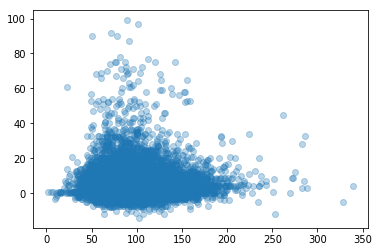

In [18]:
plt.scatter(train['VoronoiAreaNoOffenceRusher'], train['Yards'], alpha=.3)

In [19]:
yards = train.pop('Yards')
season = train.pop('Season')
season_weights = season.map({2017: .8, 2018: 1.2}).values

# Model build

In [20]:
fill_val = -999

In [21]:
X = train.copy()

y = np.zeros((yards.shape[0], 199))
for idx, target in enumerate(list(yards)):
    y[idx][99 + target] = 1

In [22]:
col_order = sorted(train.columns)
X = X[col_order]
scaler = StandardScaler()
X = scaler.fit_transform(X.fillna(fill_val))

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=SEED)
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(19695, 523) (3476, 523)
(19695, 199) (3476, 199)


In [ ]:
class CRPSCallback(Callback):
    
    def __init__(self,validation, predict_batch_size=20, include_on_batch=False):
        super(CRPSCallback, self).__init__()
        self.validation = validation
        self.predict_batch_size = predict_batch_size
        self.include_on_batch = include_on_batch
        
        print('validation shape',len(self.validation))

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_train_begin(self, logs={}):
        if not ('CRPS_score_val' in self.params['metrics']):
            self.params['metrics'].append('CRPS_score_val')

    def on_batch_end(self, batch, logs={}):
        if (self.include_on_batch):
            logs['CRPS_score_val'] = float('-inf')

    def on_epoch_end(self, epoch, logs={}):
        logs['CRPS_score_val'] = float('-inf')
            
        if (self.validation):
            X_valid, y_valid = self.validation[0], self.validation[1]
            y_pred = self.model.predict(X_valid)
            y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
            y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
            val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_valid.shape[0])
            val_s = np.round(val_s, 6)
            logs['CRPS_score_val'] = val_s

In [ ]:
def get_model(x_tr,y_tr,x_val,y_val,w_tr):
    inp = Input(shape = (x_tr.shape[1],))
    x = Dense(1024, input_dim=X.shape[1], activation='relu')(inp)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    out = Dense(199, activation='softmax')(x)
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[])

    es = EarlyStopping(
        monitor='CRPS_score_val', 
        mode='min',
        restore_best_weights=True, 
        verbose=1, 
        patience=10
    )

    mc = ModelCheckpoint(
        'best_model.h5',
        monitor='CRPS_score_val',
        mode='min',
        save_best_only=True, 
        verbose=1, 
        save_weights_only=True
    )
    
    bsz = 1024
    steps = x_tr.shape[0] / bsz
    
    model.fit(
        x_tr, 
        y_tr,
        callbacks=[CRPSCallback(validation = (x_val,y_val)),es,mc], 
        epochs=100, 
        batch_size=bsz,
        sample_weight=w_tr,
        verbose=1
    )
    model.load_weights("best_model.h5")
    
    y_pred = model.predict(x_val)
    y_valid = y_val
    y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
    val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * x_val.shape[0])
    crps = np.round(val_s, 6)

    return model,crps

In [ ]:
losses = []
models = []
crps_csv = []
s_time = time.time()

for k in range(2):
    kfold = KFold(5, random_state=SEED + k, shuffle=True)
    for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(yards)):
        print("-----------")
        print("-----------")
        tr_x, tr_y = X[tr_inds],y[tr_inds]
        val_x, val_y = X[val_inds],y[val_inds]
        w_tr = season_weights[tr_inds]
        model,crps = get_model(tr_x,tr_y,val_x,val_y,w_tr)
        models.append(model)
        print("the %d fold crps is %f"%((k_fold+1),crps))
        crps_csv.append(crps)

print("mean crps is %f"%np.mean(crps_csv))

def predict(x_te):
    model_num = len(models)
    for k,m in enumerate(models):
        if k==0:
            y_pred = m.predict(x_te, batch_size=1024)
        else:
            y_pred += m.predict(x_te, batch_size=1024)
            
    y_pred = y_pred / model_num
    
    return y_pred

-----------
-----------
validation shape 2
Epoch 1/100
18536/18536 [==============================] - 2s 106us/step - loss: 5.5910

Epoch 00001: CRPS_score_val improved from inf to 0.08178, saving model to best_model.h5
Epoch 2/100
18536/18536 [==============================] - 1s 64us/step - loss: 5.0919

Epoch 00002: CRPS_score_val improved from 0.08178 to 0.07927, saving model to best_model.h5
Epoch 3/100
18536/18536 [==============================] - 1s 64us/step - loss: 4.6383

Epoch 00003: CRPS_score_val improved from 0.07927 to 0.07658, saving model to best_model.h5
Epoch 4/100
18536/18536 [==============================] - 1s 64us/step - loss: 4.1856

Epoch 00004: CRPS_score_val improved from 0.07658 to 0.05782, saving model to best_model.h5
Epoch 5/100
18536/18536 [==============================] - 1s 64us/step - loss: 3.7678

Epoch 00005: CRPS_score_val improved from 0.05782 to 0.03467, saving model to best_model.h5
Epoch 6/100
18536/18536 [==============================] - 1

18537/18537 [==============================] - 1s 64us/step - loss: 2.7107

Epoch 00014: CRPS_score_val improved from 0.01324 to 0.01319, saving model to best_model.h5
Epoch 15/100
18537/18537 [==============================] - 1s 64us/step - loss: 2.6966

Epoch 00015: CRPS_score_val improved from 0.01319 to 0.01315, saving model to best_model.h5
Epoch 16/100
18537/18537 [==============================] - 1s 65us/step - loss: 2.6762

Epoch 00016: CRPS_score_val did not improve from 0.01315
Epoch 17/100
18537/18537 [==============================] - 1s 65us/step - loss: 2.6507

Epoch 00017: CRPS_score_val improved from 0.01315 to 0.01314, saving model to best_model.h5
Epoch 18/100
18537/18537 [==============================] - 1s 65us/step - loss: 2.6374: 0s - los

Epoch 00018: CRPS_score_val improved from 0.01314 to 0.01312, saving model to best_model.h5
Epoch 19/100
18537/18537 [==============================] - 1s 64us/step - loss: 2.6308

Epoch 00019: CRPS_score_val did not improve 

18537/18537 [==============================] - 1s 67us/step - loss: 2.5338

Epoch 00027: CRPS_score_val improved from 0.01278 to 0.01276, saving model to best_model.h5
Epoch 28/100
18537/18537 [==============================] - 1s 67us/step - loss: 2.5298

Epoch 00028: CRPS_score_val did not improve from 0.01276
Epoch 29/100
18537/18537 [==============================] - 1s 66us/step - loss: 2.5132

Epoch 00029: CRPS_score_val did not improve from 0.01276
Epoch 30/100
18537/18537 [==============================] - 1s 66us/step - loss: 2.5053

Epoch 00030: CRPS_score_val did not improve from 0.01276
Epoch 31/100
18537/18537 [==============================] - 1s 66us/step - loss: 2.4959

Epoch 00031: CRPS_score_val did not improve from 0.01276
Epoch 32/100
18537/18537 [==============================] - 1s 66us/step - loss: 2.4881

Epoch 00032: CRPS_score_val did not improve from 0.01276
Epoch 33/100
18537/18537 [==============================] - 1s 67us/step - loss: 2.4772

Epoch 00033: 

18537/18537 [==============================] - 1s 67us/step - loss: 2.4111

Epoch 00038: CRPS_score_val did not improve from 0.01202
Epoch 39/100
18537/18537 [==============================] - 1s 69us/step - loss: 2.4030

Epoch 00039: CRPS_score_val did not improve from 0.01202
Epoch 40/100
18537/18537 [==============================] - 1s 67us/step - loss: 2.3935

Epoch 00040: CRPS_score_val did not improve from 0.01202
Epoch 41/100
18537/18537 [==============================] - 1s 69us/step - loss: 2.3740

Epoch 00041: CRPS_score_val did not improve from 0.01202
Epoch 42/100
18537/18537 [==============================] - 1s 68us/step - loss: 2.3535

Epoch 00042: CRPS_score_val did not improve from 0.01202
Epoch 43/100
18537/18537 [==============================] - 1s 67us/step - loss: 2.3484

Epoch 00043: CRPS_score_val did not improve from 0.01202
Epoch 44/100
18537/18537 [==============================] - 1s 66us/step - loss: 2.3384: 0s - loss
Restoring model weights from the end o

18536/18536 [==============================] - 1s 73us/step - loss: 4.6693

Epoch 00003: CRPS_score_val improved from 0.07761 to 0.07423, saving model to best_model.h5
Epoch 4/100
18536/18536 [==============================] - 1s 72us/step - loss: 4.2157

Epoch 00004: CRPS_score_val improved from 0.07423 to 0.05993, saving model to best_model.h5
Epoch 5/100
16384/18536 [=========================>....] - ETA: 0s - loss: 3.7975

In [ ]:
print("mean crps is %f"%np.mean(crps_csv))

In [ ]:
from kaggle.competitions import nflrush

names = dict(zip(range(199), ['Yards%d' % i for i in range(-99, 100)]))

env = nflrush.make_env()
for i, (df_test, sample_pred) in enumerate(env.iter_test()):
    test = processor.initial_cleaning(df_test)
    test = processor.transform(test)    
    
    for col in col_order:
        if col not in test.columns:
            test[col] = 0
            
    test = test[col_order]
    scaled_test = scaler.transform(test.fillna(fill_val))    
    y_pred = predict(scaled_test)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1).tolist()[0]

    preds_df = pd.DataFrame(data=[y_pred], columns=sample_pred.columns)
    if i == 0:
        all_preds = preds_df
        all_test_rows = test
    else:
        all_preds = pd.concat([all_preds, preds_df], ignore_index=True, sort=False)
        all_test_rows = pd.concat([all_test_rows, test], ignore_index=True, sort=False)
    env.predict(preds_df)
all_test_rows.to_csv('X_test.csv')
env.write_submission_file()